In [2]:
import torch
import nibabel as nib
import nilearn as nl
import numpy as np
from model_class import UNET3D
import torchio as tio
from torchvision import transforms as T
from skimage.util import montage
from matplotlib import pyplot as plt
import os

model = UNET3D(in_channels=4, out_channels=64, n_classes=3)
model.load_state_dict(torch.load("model.pth"))
model.eval()

/home/ozkan/anaconda3/envs/gemini/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UNET3D(
  (double_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down_1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
       

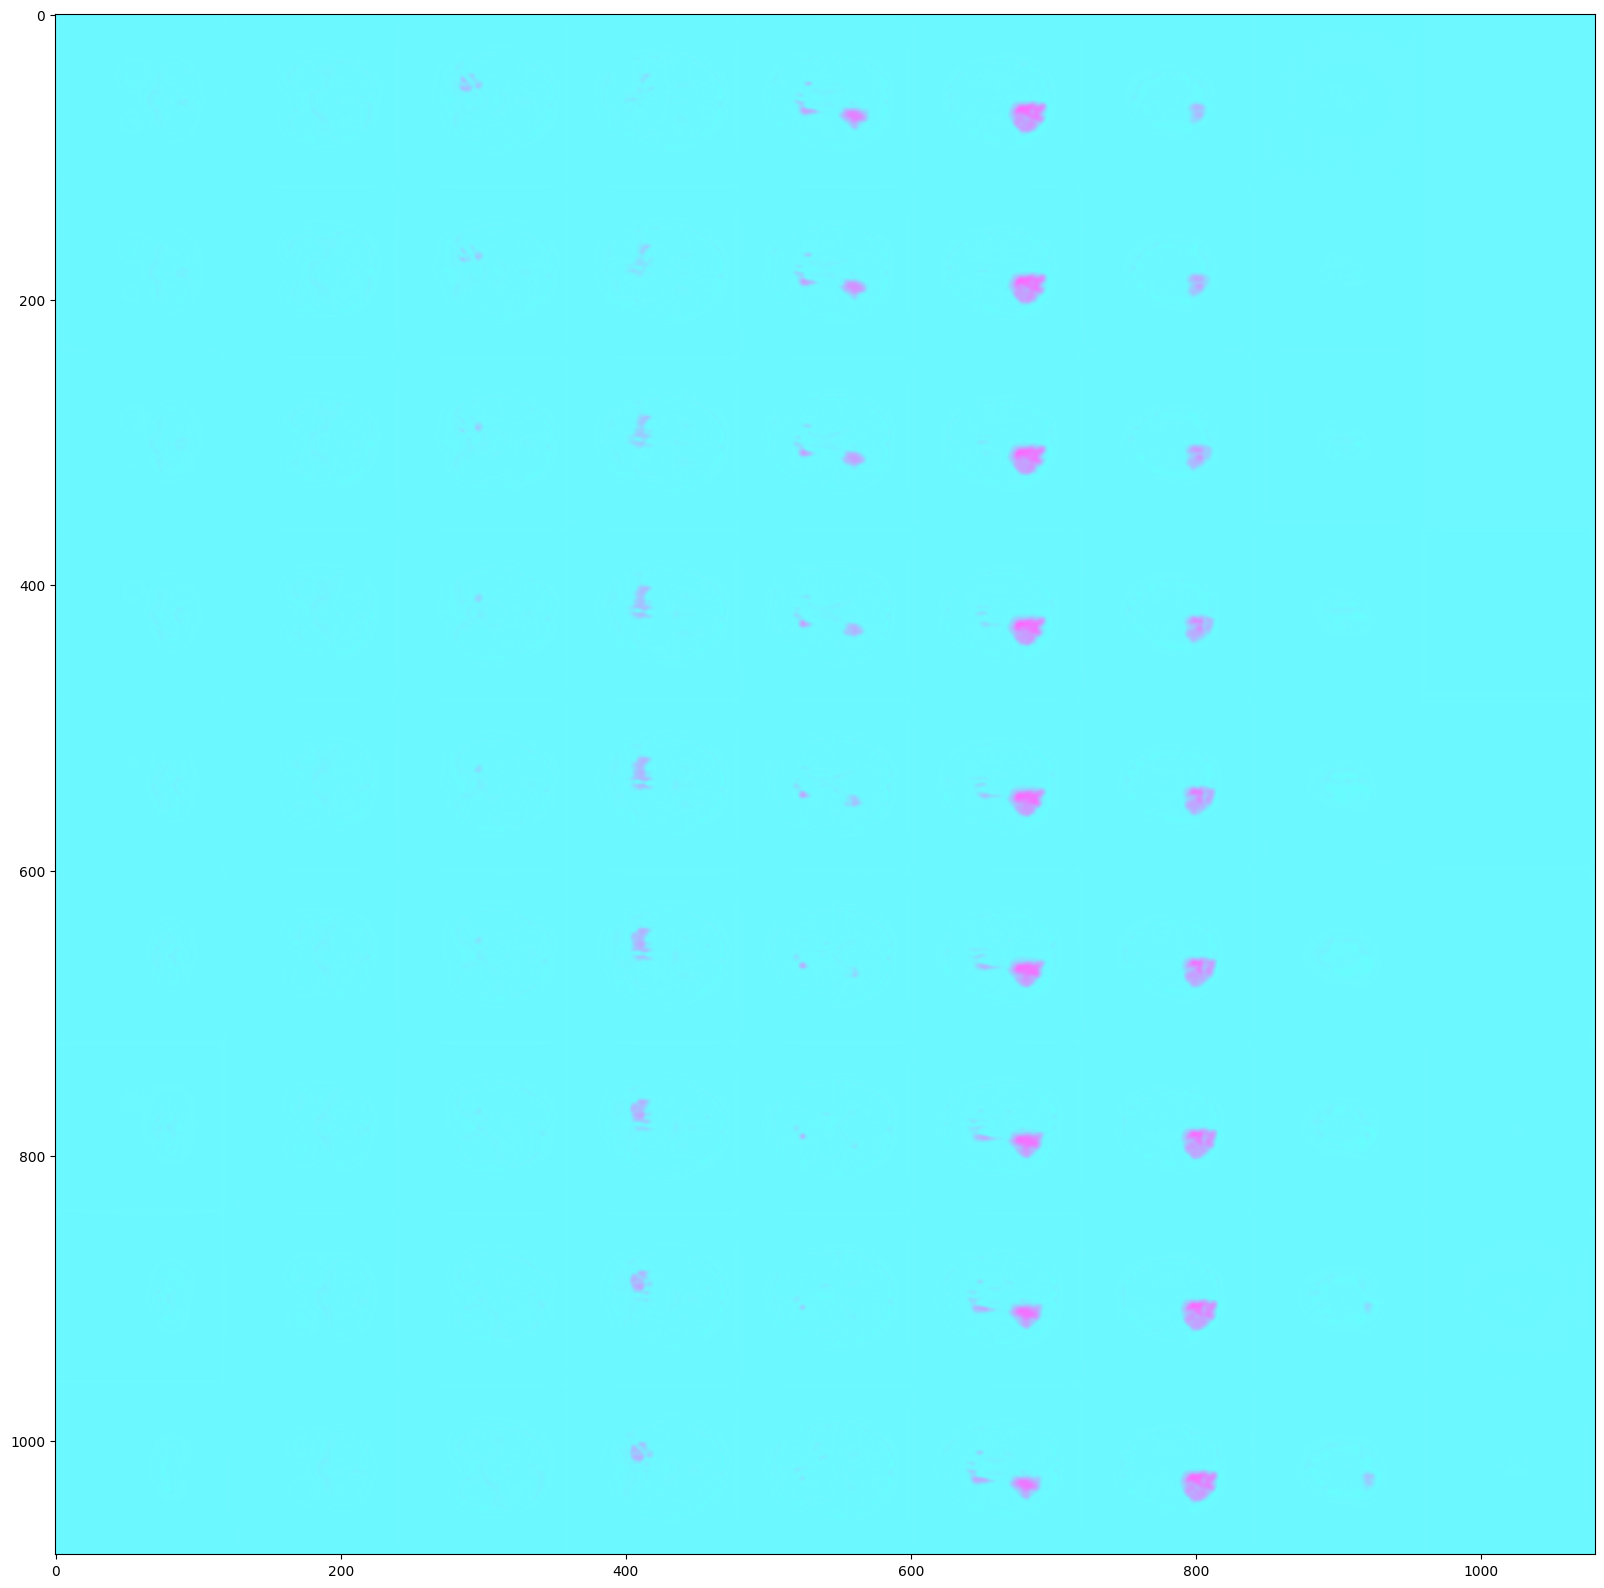

In [4]:

resample = tio.Resample((2,2,2))
example_image_file = '/home/ozkan/Desktop/gesund_task/BraTS2020_TrainingData/BraTS20_Validation_110/BraTS20_Validation_110_flair.nii'

def Normalize(image : np.ndarray):
    return (image - np.min(image))/(np.max(image) - np.min(image))

data_types =  ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
data_img = []
resample = tio.Resample((2,2,2))

with torch.no_grad():
    for data_type in data_types:
        img = tio.ScalarImage(example_image_file)
        img = resample(img)
        img = np.array(img)
        img = np.squeeze(img, axis = 0)
        img = Normalize(img)
        data_img.append(img)

    img_stack = np.stack(data_img)
    img_stack = np.moveaxis(img_stack, (0,1,2,3), (0,3,2,1))
    img_stack = torch.Tensor(img_stack)


    subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack), id = 25)
    result = model(img_stack.unsqueeze(0))
    
result_tensor = result.squeeze()[0].squeeze().cpu().detach().numpy()
mask_predict = np.rot90(montage(result_tensor))
fig, (ax1) = plt.subplots(1,1, figsize = (20, 20))
ax1.imshow(mask_predict,cmap='cool', alpha=0.6)

# With original image

In [3]:

example_image_file = '/home/ozkan/Desktop/gesund_task/BraTS20_Training_158/BraTS20_Training_158'

def Normalize(image : np.ndarray):
    return (image - np.min(image))/(np.max(image) - np.min(image))

data_types =  ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
data_img = []
resample = tio.Resample((2,2,2))


with torch.no_grad():
    for data_type in data_types:
        img = tio.ScalarImage(example_image_file + data_type) 
        img = resample(img)
        img = np.array(img)
        img = np.squeeze(img, axis = 0)
        img = Normalize(img)
        data_img.append(img)

    img_stack = np.stack(data_img)
    img_stack = np.moveaxis(img_stack, (0,1,2,3), (0,3,2,1))
    img_stack = torch.Tensor(img_stack)


    subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack), id = 25)
    result = model(img_stack.unsqueeze(0))

torch.Size([1, 512, 9, 15, 15])


In [4]:
def ConvertToMultiChannel(labels):
   label_TC = labels.copy()
   label_TC[label_TC == 1] = 1
   label_TC[label_TC == 2] = 0
   label_TC[label_TC == 4] = 1
   
   
   label_WT = labels.copy()
   label_WT[label_WT == 1] = 1
   label_WT[label_WT == 2] = 1
   label_WT[label_WT == 4] = 1
   
   label_ET = labels.copy()
   label_ET[label_ET == 1] = 0
   label_ET[label_ET == 2] = 0
   label_ET[label_ET == 4] = 1
   
   label_stack = np.stack([label_WT, label_TC, label_ET])
   label_stack = np.moveaxis(label_stack, (0,1,2,3), (0,3,2,1))
   return label_stack

In [5]:
example_mask = '/home/ozkan/Desktop/gesund_task/BraTS20_Training_158/BraTS20_Training_158_seg.nii'

labels = tio.LabelMap(example_mask)
labels = resample(labels)
labels = np.array(labels)
labels = np.squeeze(labels, axis = 0)
label_stack = ConvertToMultiChannel(labels)
label_stack = torch.Tensor(label_stack)
label = tio.LabelMap(tensor = (label_stack > 0.5))

In [6]:
mask_tensor = label.data.squeeze()[0].squeeze().cpu().detach().numpy()
mask = np.rot90(montage(mask_tensor))


image_tensor = subjects.image.data.squeeze()[1].cpu().detach().numpy()
image = np.rot90(montage(image_tensor))

predict_tensor = result.squeeze()[0].squeeze().cpu().detach().numpy()
mask_predict = np.rot90(montage(predict_tensor))



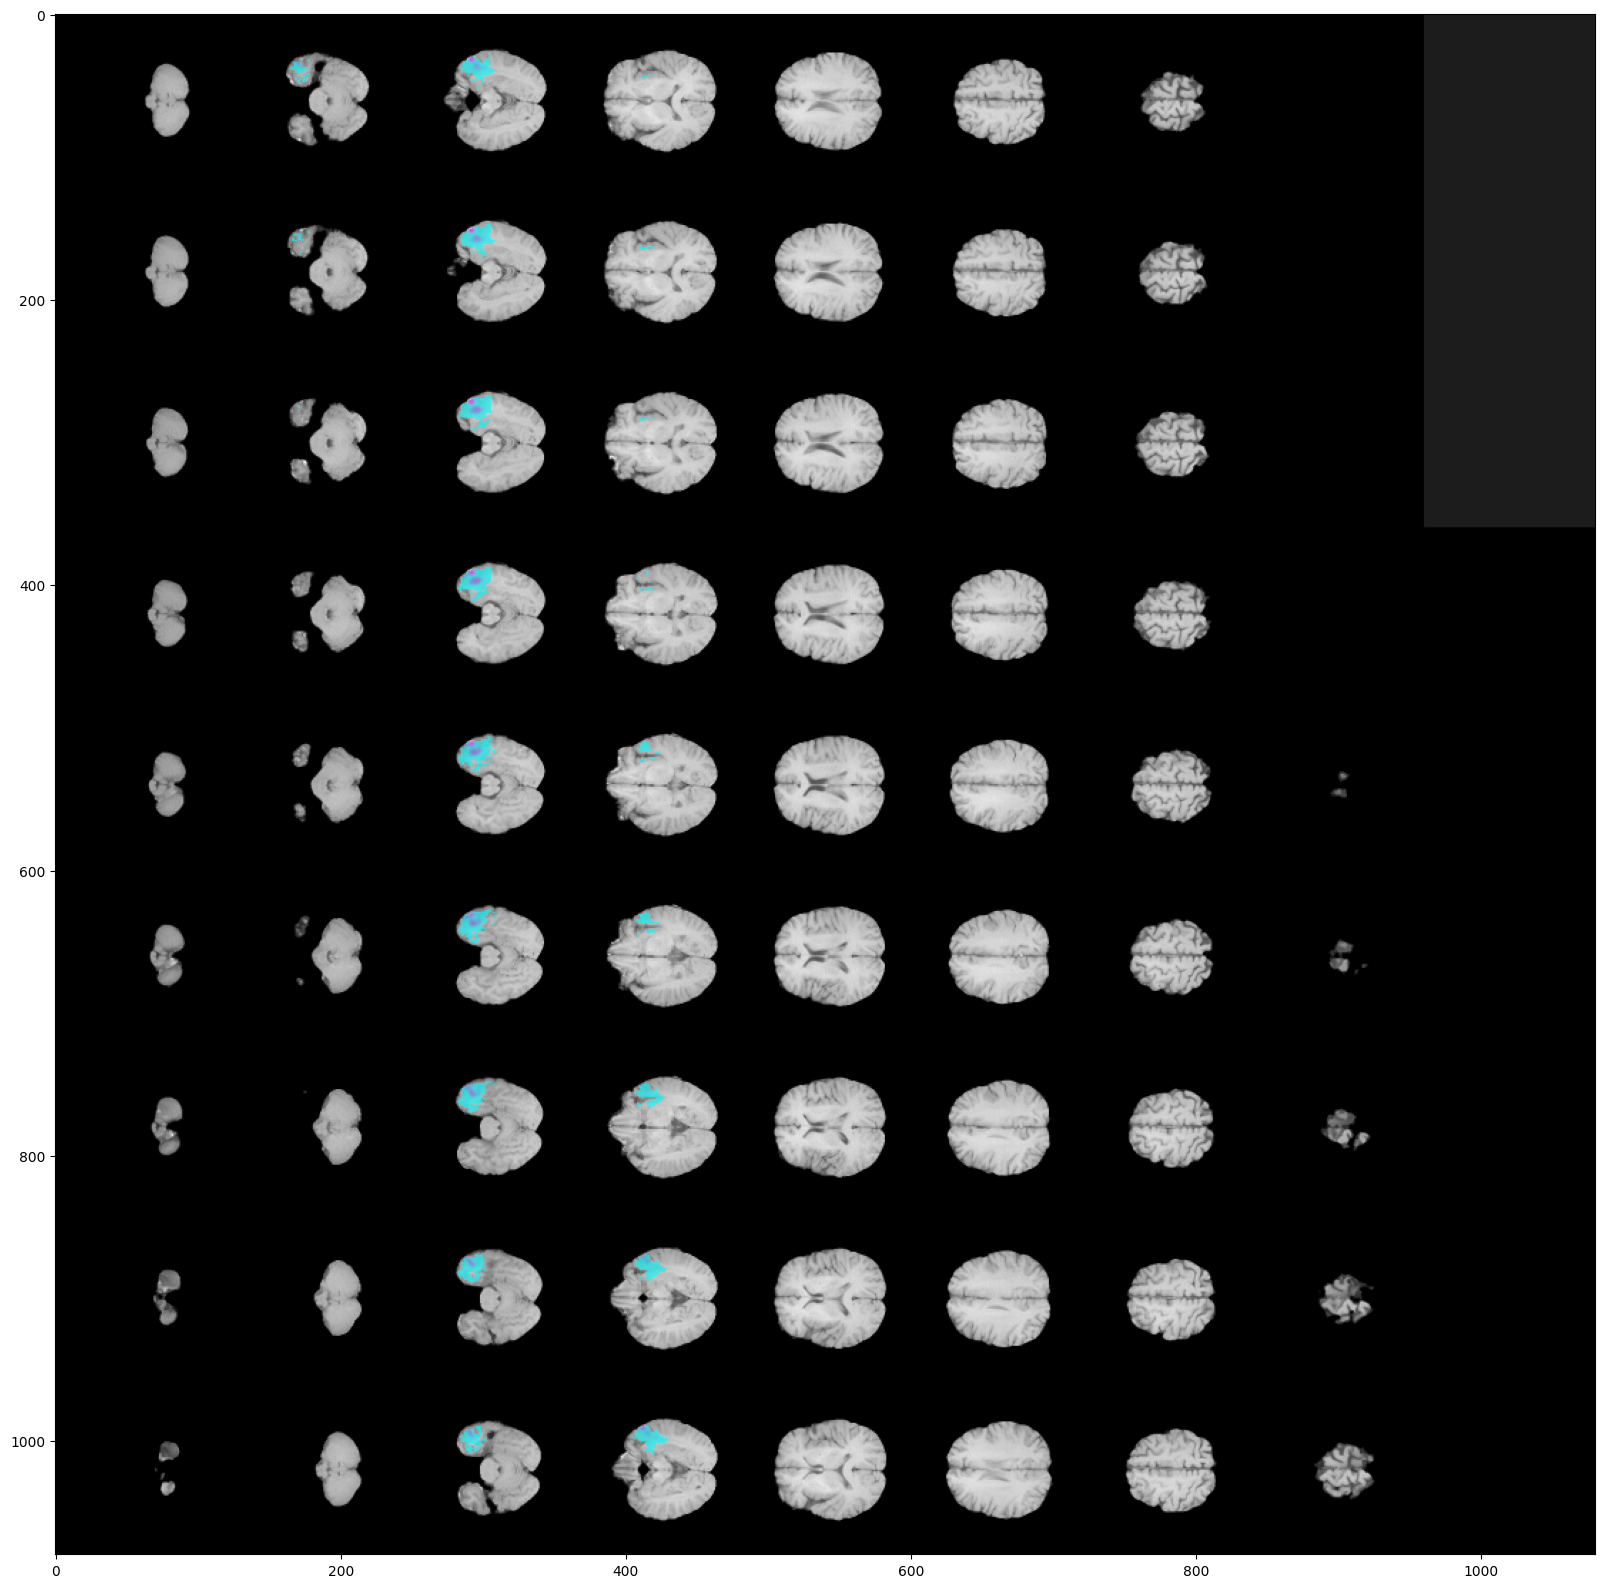

In [7]:
fig, (ax1 ) = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(image,cmap = 'gray')
ax1.imshow(np.ma.masked_where(mask == False, mask_predict),cmap='cool', alpha=0.6)
